# Multi-Class Classification with `Trainer` and `OIG-moderation` dataset
## Based on Huggingface Sagemaker-sdk - Getting Started Demo
#### Ed Lee

1. [Introduction](#Introduction)  
2. [Development Environment and Permissions](#Development-Environment-and-Permissions)
    1. [Installation](#Installation)  
    2. [Development environment](#Development-environment)  
    3. [Permissions](#Permissions)
3. [Processing](#Preprocessing)   
    1. [Tokenization](#Tokenization)  
    2. [Uploading data to sagemaker_session_bucket](#Uploading-data-to-sagemaker_session_bucket)  
4. [Fine-tuning & starting Sagemaker Training Job](#Fine-tuning-\&-starting-Sagemaker-Training-Job)  
    1. [Creating an Estimator and start a training job](#Creating-an-Estimator-and-start-a-training-job)  
    2. [Estimator Parameters](#Estimator-Parameters)   
    3. [Download fine-tuned model from s3](#Download-fine-tuned-model-from-s3)
    3. [Attach to old training job to an estimator ](#Attach-to-old-training-job-to-an-estimator)  
5. [_Coming soon_:Push model to the Hugging Face hub](#Push-model-to-the-Hugging-Face-hub)

# Introduction

Welcome to our end-to-end Multi-Class Text-Classification example. In this demo, we will use the Hugging Faces `transformers` and `datasets` library together with a custom Amazon sagemaker-sdk extension to fine-tune a pre-trained transformer on muti-class text classification. In particular, the pre-trained model will be fine-tuned using the `OIG-moderation` dataset. To get started, we need to set up the environment with a few prerequisite steps, for permissions, configurations, and so on. 

_**NOTE: You can run this demo in Sagemaker Studio, your local machine or Sagemaker Notebook Instances**_

# Development Environment and Permissions 

## Installation

* Select notebook kernel on Sagemaker: PyTorch 1.13 Python 3.9

_*Note:* we only install the required libraries from Hugging Face and AWS. You also need PyTorch or Tensorflow, if you haven´t it installed_

In [6]:
!pip install "sagemaker>=2.140.0" "transformers==4.26.1" "datasets[s3]==2.10.1" "ipywidgets" --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 1.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.9/214.9 kB 3.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 21.3 MB/s eta 0:00:00:00:01

[notice] A new release of pip is available: 23.0 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


## Development environment 

In [3]:
import sagemaker.huggingface

_If you are going to use Sagemaker in a local environment. You need access to an IAM Role with the required permissions for Sagemaker. You can find [here](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html) more about it._

## Permissions

In [4]:
import sagemaker
import boto3
sess = sagemaker.Session()
# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it not exists
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker role arn: arn:aws:iam::391015568214:role/service-role/AmazonSageMaker-ExecutionRole-20231024T120029
sagemaker bucket: sagemaker-us-east-2-391015568214
sagemaker session region: us-east-2


# Preprocessing

We are using the `datasets` library to download and preprocess the `OIG-moderation` dataset. After preprocessing, the dataset will be uploaded to our `sagemaker_session_bucket` to be used within our training job. 

https://huggingface.co/datasets/ontocord/OIG-moderation

## Tokenization 

In [5]:
import torch
from datasets import load_dataset
from datasets import Dataset 
from transformers import AutoTokenizer
import pandas as pd
import numpy as np


# tokenizer used in preprocessing
tokenizer_name = 'distilbert-base-uncased'

# dataset used
dataset_name = 'ontocord/OIG-moderation'

# s3 key prefix for the data
s3_prefix = 'samples/datasets/OIG-moderation'

## Must Login to Hugging Face Hub  to Download OIG-moderation
Please create an API key in Settings -> Access Tokens and enter when prompted below.

In [158]:
from huggingface_hub import notebook_login

notebook_login()

In [6]:
from datasets import load_dataset

# If the dataset is gated/private, make sure you have run huggingface-cli login

loaded_dataset = load_dataset(dataset_name) # smaller the size for dataset to 10k for faster iterating


Found cached dataset json (/root/.cache/huggingface/datasets/ontocord___json/ontocord--OIG-moderation-0dac4560d8f6e324/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51)


  0%|          | 0/1 [00:00<?, ?it/s]

## Data Cleaning for the OIG-moderation Dataset

In [19]:
from datasets import Dataset 
import pandas as pd
import numpy as np

# Sample down for faster iteration, ok for illustrative purposes.
SAMPLE_SIZE = 20000
CLASS_LABEL_COL = 'str_labels'
orig_df = pd.DataFrame(loaded_dataset).sample(n=SAMPLE_SIZE, random_state=1)

Casting to class labels:   0%|          | 0/16060 [00:00<?, ? examples/s]

Map:   0%|          | 0/16060 [00:00<?, ? examples/s]

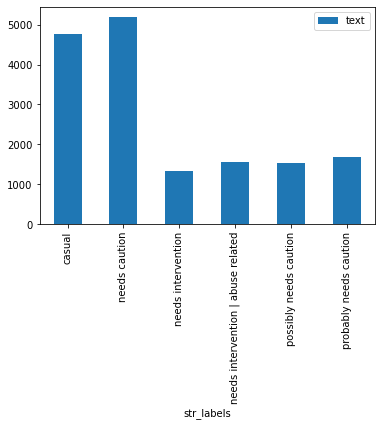

In [20]:
def get_parsed_df(orig_df):
    parsed_df = orig_df.copy()
    parsed_df['old_text'] = parsed_df['train'].apply(lambda x: x.get("text"))
    split_text = parsed_df['old_text'].str.split('\n')
    parsed_df['text'] = split_text.str[0].str.split(':').str[1].str.strip()
    parsed_df[CLASS_LABEL_COL] = split_text.str[1].str.split(':').str[1].str.strip()
    return parsed_df

def get_cleaned_labels_df(orig_df):
    """Remove examples that are of very low count."""
    MIN_IN_CATEGORY = 1000
    df_low_value_counts = orig_df.groupby(CLASS_LABEL_COL).count()
    filter_df = df_low_value_counts.reset_index()[df_low_value_counts.reset_index().train > MIN_IN_CATEGORY]
    return orig_df.merge(filter_df[CLASS_LABEL_COL], on=CLASS_LABEL_COL, how='inner')

def get_remove_missing_and_fix_spelling_df(orig_df):
    df = orig_df.copy()
    df = df[['text', CLASS_LABEL_COL]]
    df = orig_df[orig_df[CLASS_LABEL_COL].str.len() > 0]
    df[CLASS_LABEL_COL] = df[CLASS_LABEL_COL].replace({"causual": "casual"})  # replace spelling mistake in outcomes
    df = df[df['text'].notna()]  # exclude rows that are NA
    df = df.loc[df['text'].str.strip() != '', :]  # exclude rows with empty string
    return df

df = orig_df.pipe(get_parsed_df).pipe(get_cleaned_labels_df).pipe(get_remove_missing_and_fix_spelling_df)
df = df[['text', CLASS_LABEL_COL]]

df.groupby(CLASS_LABEL_COL).count().plot.bar()

dataset = Dataset.from_pandas(df, preserve_index=False)
dataset = dataset.class_encode_column(CLASS_LABEL_COL)

# Need to represent labels columns as tensors
labels = [label for label in dataset.features[CLASS_LABEL_COL].names]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}

def to_onehot_tensor(row):
    """ 1-hot encodes a tensor """
    # Training won't run if don't cast as floats 
    # https://discuss.pytorch.org/t/multi-label-binary-classification-result-type-float-cant-be-cast-to-the-desired-output-type-long/117915
    row['labels_onehot'] = np.eye(len(labels), dtype='uint8')[row[CLASS_LABEL_COL]].astype(np.float32).tolist()
    return row

dataset = dataset.map(to_onehot_tensor, batched=True)
dataset = dataset.rename_column("labels_onehot", "labels")


In [22]:
# download tokenizer
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True)

split_ds = dataset.train_test_split(test_size=0.2)

# tokenize dataset
train_dataset = split_ds['train'].map(tokenize, batched=True)
test_dataset = split_ds['test'].map(tokenize, batched=True)

# # set format for pytorch
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

Map:   0%|          | 0/12848 [00:00<?, ? examples/s]

Map:   0%|          | 0/3212 [00:00<?, ? examples/s]

In [23]:
# Check the data
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=10)
next(iter(dataloader))

[2023-10-26 19:08:43.212: W smdistributed/modelparallel/torch/nn/predefined_hooks.py:78] Found unsupported HuggingFace version 4.26.1 for automated tensor parallelism. HuggingFace modules will not be automatically distributed. You can use smp.tp_register_with_module API to register desired modules for tensor parallelism, or directly instantiate an smp.nn.DistributedModule. Supported HuggingFace transformers versions for automated tensor parallelism: ['4.17.0', '4.20.1', '4.21.0']


INFO:root:Using NamedTuple = typing._NamedTuple instead.


[2023-10-26 19:08:43.240 pytorch-1-13-gpu-py-ml-g4dn-xlarge-93fa10c7f16e176d479999e56114:2106 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-10-26 19:08:43.259 pytorch-1-13-gpu-py-ml-g4dn-xlarge-93fa10c7f16e176d479999e56114:2106 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


{'labels': tensor([[0., 1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 1., 0.],
         [0., 1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.]]),
 'input_ids': tensor([[  101,  3057,  2360,  ...,     0,     0,     0],
         [  101,  2062,  2013,  ...,     0,     0,     0],
         [  101,  2054,  2079,  ...,     0,     0,     0],
         ...,
         [  101,  2016, 10855,  ...,     0,     0,     0],
         [  101,  1045,  2074,  ...,     0,     0,     0],
         [  101,  2204,  2559,  ...,     0,     0,     0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]])}

 more details about your research'}] more details about your research'}]## Uploading data to `sagemaker_session_bucket`

After we processed the `datasets` we are going to use the new `FileSystem` [integration](https://huggingface.co/docs/datasets/filesystems.html) to upload our dataset to S3.

In [24]:
# save train_dataset to s3
training_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/train'
train_dataset.save_to_disk(training_input_path)

# save test_dataset to s3
test_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/test'
test_dataset.save_to_disk(test_input_path)


Saving the dataset (0/1 shards):   0%|          | 0/12848 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3212 [00:00<?, ? examples/s]

# Fine-tuning & starting Sagemaker Training Job

In order to create a sagemaker training job we need an `HuggingFace` Estimator. The Estimator handles end-to-end Amazon SageMaker training and deployment tasks. In a Estimator we define, which fine-tuning script should be used as `entry_point`, which `instance_type` should be used, which `hyperparameters` are passed in .....



```python
huggingface_estimator = HuggingFace(entry_point='train_multiclass.py',
                            source_dir='./scripts',
                            base_job_name='huggingface-sdk-extension',
                            instance_type='ml.p3.2xlarge',
                            instance_count=1,
                            transformers_version='4.4',
                            pytorch_version='1.6',
                            py_version='py36',
                            role=role,
                            hyperparameters = {'epochs': 1,
                                               'train_batch_size': 32,
                                               'model_name':'distilbert-base-uncased'
                                                })
```

When we create a SageMaker training job, SageMaker takes care of starting and managing all the required ec2 instances for us with the `huggingface` container, uploads the provided fine-tuning script `train.py` and downloads the data from our `sagemaker_session_bucket` into the container at `/opt/ml/input/data`. Then, it starts the training job by running. 

```python
/opt/conda/bin/python train.py --epochs 1 --model_name distilbert-base-uncased --train_batch_size 32
```

The `hyperparameters` you define in the `HuggingFace` estimator are passed in as named arguments. 

Sagemaker is providing useful properties about the training environment through various environment variables, including the following:

* `SM_MODEL_DIR`: A string that represents the path where the training job writes the model artifacts to. After training, artifacts in this directory are uploaded to S3 for model hosting.

* `SM_NUM_GPUS`: An integer representing the number of GPUs available to the host.

* `SM_CHANNEL_XXXX:` A string that represents the path to the directory that contains the input data for the specified channel. For example, if you specify two input channels in the HuggingFace estimator’s fit call, named `train` and `test`, the environment variables `SM_CHANNEL_TRAIN` and `SM_CHANNEL_TEST` are set.


To run your training job locally you can define `instance_type='local'` or `instance_type='local_gpu'` for gpu usage. _Note: this does not working within SageMaker Studio_


In [25]:
!pygmentize ./scripts/train_multiclass.py

from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer
from transformers import EvalPrediction

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from datasets import load_from_disk
import numpy as np

import random
import logging
import sys
import argparse
import os
import torch

if __name__ == "__main__":

    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.
    parser.add_argument("--epochs", type=int, default=3)
    parser.add_argument("--train_batch_size", type=int, default=32)
    parser.add_argument("--eval_batch_size", type=int, default=64)
    parser.add_argument("--warmup_steps", type=int, default=500)
    parser.add_argument("--model_name", type=str)
    parser.add_argument("--learning_rate", type=str, default=5e-5)

    # Data, model, and output directorie

## Creating an Estimator and start a training job

In [29]:
from sagemaker.huggingface import HuggingFace

# hyperparameters, which are passed into the training job
hyperparameters={'epochs': 3,
                 'train_batch_size': 32,
                 'model_name':'distilbert-base-uncased'
                 }

instance_type = 'ml.p3.16xlarge'
# instance_type = 'ml.p3.2xlarge'

In [71]:
huggingface_estimator = HuggingFace(entry_point='train_multiclass.py',
                            source_dir='./scripts',
                            instance_type=instance_type,
                            instance_count=1,
                            role=role,
                            transformers_version='4.26',
                            pytorch_version='1.13',
                            py_version='py39',
                            hyperparameters = hyperparameters)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [70]:
from sagemaker.huggingface import HuggingFace

# configuration for running training on smdistributed Data Parallel

distribution = {'smdistributed':{'dataparallel':{ 'enabled': True }}}
instance_type = 'ml.p3.16xlarge'
instance_count = 2


# hyperparameters, which are passed into the training job
hyperparameters={
    'model_id': tokenizer_name,
    'epochs': 3,
    'per_device_train_batch_size': 32,
    'per_device_eval_batch_size': 32,
    'learning_rate': 3e-5,
    'fp16': True,
    'save_total_limit':2,
    'load_best_model_at_end':True,
    'metric_for_best_model':"f1",
    'doc_stride': 128,
    'pad_to_max_length': True,
    'output_dir': '/opt/ml/model'
}

# configuration for running training on smdistributed Data Parallel
distribution = {'smdistributed':{'dataparallel':{ 'enabled': True }}}


git_config = {'repo': 'https://github.com/huggingface/transformers.git','branch': 'v4.26.0'}
metric_definitions=[
     {"Name": "train_runtime", "Regex": "train_runtime.*=\D*(.*?)$"},
     {'Name': 'train_samples_per_second', 'Regex': "train_samples_per_second.*=\D*(.*?)$"},
     {'Name': 'epoch', 'Regex': "epoch.*=\D*(.*?)$"},
     {'Name': 'f1', 'Regex': "f1.*=\D*(.*?)$"},
     {'Name': 'exact_match', 'Regex': "exact_match.*=\D*(.*?)$"}]
volume_size=200

huggingface_estimator = HuggingFace(
                            entry_point='train_multiclass.py',
                            source_dir='./scripts',
                            instance_type='ml.p3.16xlarge',
                            git_config=git_config,
                            metric_definitions=metric_definitions,
                            instance_type=instance_type,
                            instance_count=instance_count,
                            volume_size=volume_size,
                            role=role,
                            transformers_version='4.26.0',
                            pytorch_version='1.13.1',
                            py_version='py39',
                            distribution=distribution,
                            hyperparameters=hyperparameters)

╭──────────────────────────────────────────────────────────────────────────────────────────────────╮
│  <ipython-input-70-b9a693e3f86f>:39                                                              │
│                                                                                                  │
│ ▲                                                                                                │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
SyntaxError: keyword argument repeated: instance_type

## Creating an Estimator and Start Training Job

In [31]:
# starting the train job with our uploaded datasets as input
huggingface_estimator.fit({'train': training_input_path, 'test': test_input_path})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: huggingface-pytorch-training-2023-10-26-19-12-25-308


Using provided s3_resource
2023-10-26 19:12:25 Starting - Starting the training job......
2023-10-26 19:13:22 Starting - Preparing the instances for training.........
2023-10-26 19:14:35 Downloading - Downloading input data...
2023-10-26 19:15:00 Training - Downloading the training image.................................
2023-10-26 19:20:47 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-10-26 19:21:11,409 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-10-26 19:21:11,471 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-10-26 19:21:11,483 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-10-26 19:21:11,486 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-10-26 19:21:11,818 sagemaker-t

## Deploying the endpoint

To deploy our endpoint, we call `deploy()` on our HuggingFace estimator object, passing in our desired number of instances and instance type.

In [32]:
predictor = huggingface_estimator.deploy(1, "ml.g4dn.xlarge")

INFO:sagemaker:Creating model with name: huggingface-pytorch-training-2023-10-26-19-25-59-385
INFO:sagemaker:Creating endpoint-config with name huggingface-pytorch-training-2023-10-26-19-25-59-385
INFO:sagemaker:Creating endpoint with name huggingface-pytorch-training-2023-10-26-19-25-59-385


-------------!

Then, we use the returned predictor object to call the endpoint.

In [69]:
happy_input = {"inputs": "Good morning how are you today?"}
black_eye_pea_lyrics = {"inputs": "Overseas, yeah, we tryna stop terrorism but we still got terrorists here livin' in the USA, the big CIA The Bloods and the Crips and the KKK"}

print(predictor.predict(happy_input))
print(predictor.predict(black_eye_pea_lyrics))


[{'label': 'casual', 'score': 0.7036333084106445}]
[{'label': 'needs caution', 'score': 0.6842705607414246}]


Finally, we delete the endpoint again.

In [356]:
predictor.delete_model()
predictor.delete_endpoint()

INFO:sagemaker:Deleting model with name: huggingface-pytorch-training-2023-10-25-06-52-57-698
INFO:sagemaker:Deleting endpoint configuration with name: huggingface-pytorch-training-2023-10-25-06-52-57-698
INFO:sagemaker:Deleting endpoint with name: huggingface-pytorch-training-2023-10-25-06-52-57-698


# Extras

### Estimator Parameters

In [337]:
# container image used for training job
print(f"container image used for training job: \n{huggingface_estimator.image_uri}\n")

# s3 uri where the trained model is located
print(f"s3 uri where the trained model is located: \n{huggingface_estimator.model_data}\n")

# latest training job name for this estimator
print(f"latest training job name for this estimator: \n{huggingface_estimator.latest_training_job.name}\n")



container image used for training job: 
None

s3 uri where the trained model is located: 
s3://sagemaker-us-east-2-391015568214/huggingface-pytorch-training-2023-10-25-06-39-03-508/output/model.tar.gz

latest training job name for this estimator: 
huggingface-pytorch-training-2023-10-25-06-39-03-508



In [338]:
# access the logs of the training job
huggingface_estimator.sagemaker_session.logs_for_job(huggingface_estimator.latest_training_job.name)

2023-10-25 06:52:03 Starting - Preparing the instances for training
2023-10-25 06:52:03 Downloading - Downloading input data
2023-10-25 06:52:03 Training - Training image download completed. Training in progress.
2023-10-25 06:52:03 Uploading - Uploading generated training model
2023-10-25 06:52:03 Completed - Training job completedbash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-10-25 06:47:43,564 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-10-25 06:47:43,585 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-10-25 06:47:43,598 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-10-25 06:47:43,601 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-10-25 06:47:43,891 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)

### Attach to old training job to an estimator 

In Sagemaker you can attach an old training job to an estimator to continue training, get results etc..

In [ ]:
from sagemaker.estimator import Estimator

# job which is going to be attached to the estimator
old_training_job_name=''

In [ ]:
# attach old training job
huggingface_estimator_loaded = Estimator.attach(old_training_job_name)

# get model output s3 from training job
huggingface_estimator_loaded.model_data